<a href="https://colab.research.google.com/github/devger04/Loopwise/blob/main/taximl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loopwise Machine Learning Implementation

In [ ]:
!pip install basemap

In [ ]:
!pip install basemap-data-hires

In [ ]:
!pip install mplleaflet --upgrade

In [71]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import folium

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm, colors
import mplleaflet as mpl
%matplotlib inline

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [72]:
rides = pd.read_csv('/content/sample_data/uber-raw-data-aug14.csv.zip')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  829275 non-null  object 
 1   Lat        829275 non-null  float64
 2   Lon        829275 non-null  float64
 3   Base       829275 non-null  object 
dtypes: float64(2), object(2)
memory usage: 25.3+ MB


# Data Preprocessing

In [73]:
rides.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


In [74]:
rides.columns = ['timestamp', 'lat', 'lon', 'base']

In [75]:
ti = time.time()

rides['timestamp'] = pd.to_datetime(rides['timestamp'])

tf = time.time()
print(tf-ti,' seconds.')

5.44735312461853  seconds.


In [76]:
rides.to_pickle('./test_data.pkl')
# rides = pd.read_pickle('./test_data.pkl')

In [77]:
rides['weekday'] = rides.timestamp.dt.day_name()
rides['month'] = rides.timestamp.dt.month
rides['day'] = rides.timestamp.dt.day
rides['hour'] = rides.timestamp.dt.hour
rides['minute'] = rides.timestamp.dt.minute

## customized features
# rides['month_name'] = rides.timestamp.dt.strftime('%B')
# rides['day_hour'] = rides.timestamp.dt.strftime('%d-%H')

## ocular analysis
rides.head()

,timestamp,lat,lon,base,weekday,month,day,hour,minute
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,Friday,8,1,0,3
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,Friday,8,1,0,9
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,Friday,8,1,0,12
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,Friday,8,1,0,12
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,Friday,8,1,0,12


In [78]:
day_map = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

rides['weekday'] = pd.Categorical(rides['weekday'], categories=day_map, ordered=True)

In [79]:
## groupby operation
hourly_ride_data_without_coords = rides.groupby(['day','hour','weekday'], as_index=False)['timestamp'].count()

## rename column
hourly_ride_data_without_coords = hourly_ride_data_without_coords.rename(columns = {'timestamp':'ride_count'})

# Filter out rows with zero ride counts
hourly_ride_data_without_coords = hourly_ride_data_without_coords[hourly_ride_data_without_coords['ride_count'] > 0]

## reset index
hourly_ride_data_without_coords = hourly_ride_data_without_coords.reset_index()

# First, calculate the centroid (average) latitude and longitude for each combination of day, hour, and weekday
centroids = rides.groupby(['day', 'hour', 'weekday']).agg({
    'lat': 'mean',  # Average latitude
    'lon': 'mean'   # Average longitude
}).reset_index()

# Now merge the centroids with the hourly ride data based on ['day', 'hour', 'weekday']
hourly_ride_data = pd.merge(hourly_ride_data_without_coords, centroids, on=['day', 'hour', 'weekday'], how='left')

hourly_ride_data['ride_count'] = hourly_ride_data['ride_count'].astype('int32')

# Now `hourly_ride_data_with_coords` contains ride counts and the corresponding lat/lon
print(hourly_ride_data.head())

   index  day  hour weekday  ride_count        lat        lon
0      4    1     0  Friday         734  40.734647 -73.978049
1     11    1     1  Friday         451  40.735422 -73.980761
2     18    1     2  Friday         289  40.737882 -73.977767
3     25    1     3  Friday         318  40.743000 -73.975164
4     32    1     4  Friday         412  40.737484 -73.962356


<ipython-input-79-c54568aae85f>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_ride_data_without_coords = rides.groupby(['day','hour','weekday'], as_index=False)['timestamp'].count()
<ipython-input-79-c54568aae85f>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centroids = rides.groupby(['day', 'hour', 'weekday']).agg({


In [80]:
## groupby operation
weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean().reset_index()

## rename column
weekday_hourly_avg = weekday_hourly_avg.rename(columns = {'ride_count':'average_rides'})

## sort by categorical index
weekday_hourly_avg = weekday_hourly_avg.sort_values(by='average_rides')

## ocular analysis
weekday_hourly_avg.head()

<ipython-input-80-b4713ae99df3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean().reset_index()


,weekday,hour,average_rides
26,Tuesday,2,127.00
2,Monday,2,140.00
50,Wednesday,2,166.25
1,Monday,1,171.00
25,Tuesday,1,183.25


In [81]:
tableau_color_blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

for i in range(len(tableau_color_blind)):
    r, g, b = tableau_color_blind[i]
    tableau_color_blind[i] = (r / 255., g / 255., b / 255.)

<ipython-input-82-7098d16fb614>:9: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.pointplot(ax=ax, x='hour',y='average_rides',hue='weekday',


Text(0.5, 0, 'Hour')

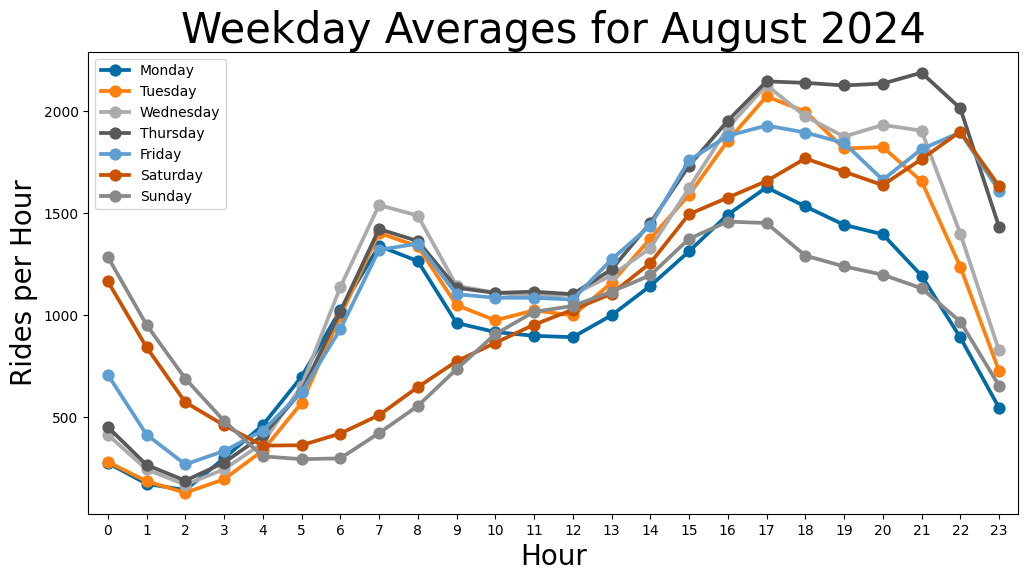

In [82]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='average_rides',hue='weekday',
              palette = current_palette, data = weekday_hourly_avg)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Weekday Averages for August 2024', fontsize=30)
ax.set_ylabel('Rides per Hour', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

In [83]:
def heat_map(ax_loc,title_str,rides_this_hour,nsew):

    ## get the axis
    ax = fig.add_subplot(ax_loc)

    ## make the basemap object
    m = Basemap(projection='merc', urcrnrlat=nsew[0], llcrnrlat=nsew[1],
                urcrnrlon=nsew[2], llcrnrlon=nsew[3], lat_ts=nsew[1], resolution='f')

    ## draw the background features
    m.drawmapboundary(fill_color = 'xkcd:light blue')
    m.fillcontinents(color='xkcd:grey', zorder = 1)
    m.drawcoastlines()
    m.drawrivers()

    ## project the GPS coordinates onto the x,y representation
    x, y = m(rides_this_hour['lon'].values, rides_this_hour['lat'].values)

    ## count the instances using the hexbin method and plot the results
    m.hexbin(x, y, gridsize=1000, mincnt = 1, bins = 'log', cmap=cm.YlOrRd, zorder = 2);

    ## set the title
    ax.set_title(title_str, fontsize=24)

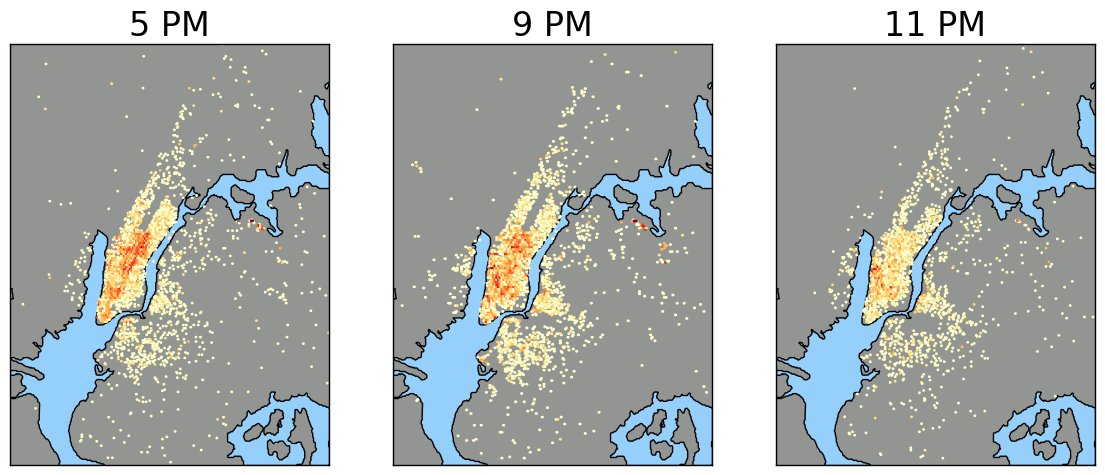

In [84]:
## set weekday for analysis
target_day = 'Thursday'

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9, 40.6, -73.8, -74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## target hours
hrs = [17, 21, 23]

## axis subplot locations
ax_loc = [131, 132, 133]

## title strings
title_str = ['5 PM', '9 PM', '11 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['weekday'] == target_day) & (rides['hour'] == hrs[ii])]

    ##  plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

In [85]:
hourly_ride_data.head()

,index,day,hour,weekday,ride_count,lat,lon
0,4,1,0,Friday,734,40.734647,-73.978049
1,11,1,1,Friday,451,40.735422,-73.980761
2,18,1,2,Friday,289,40.737882,-73.977767
3,25,1,3,Friday,318,40.743000,-73.975164
4,32,1,4,Friday,412,40.737484,-73.962356


In [86]:
thursday_hourly_data = hourly_ride_data[hourly_ride_data['weekday']=='Thursday']

<ipython-input-87-b522bb6fcef6>:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day', palette = current_palette, data = thursday_hourly_data)


Text(0.5, 0, 'Hour')

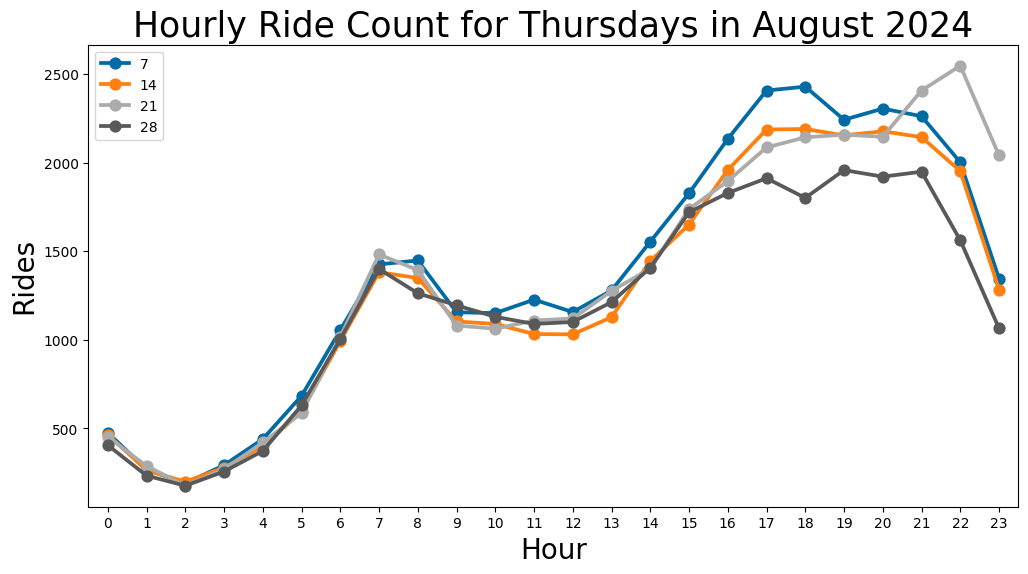

In [87]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day', palette = current_palette, data = thursday_hourly_data)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Hourly Ride Count for Thursdays in August 2024', fontsize=25)
ax.set_ylabel('Rides', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

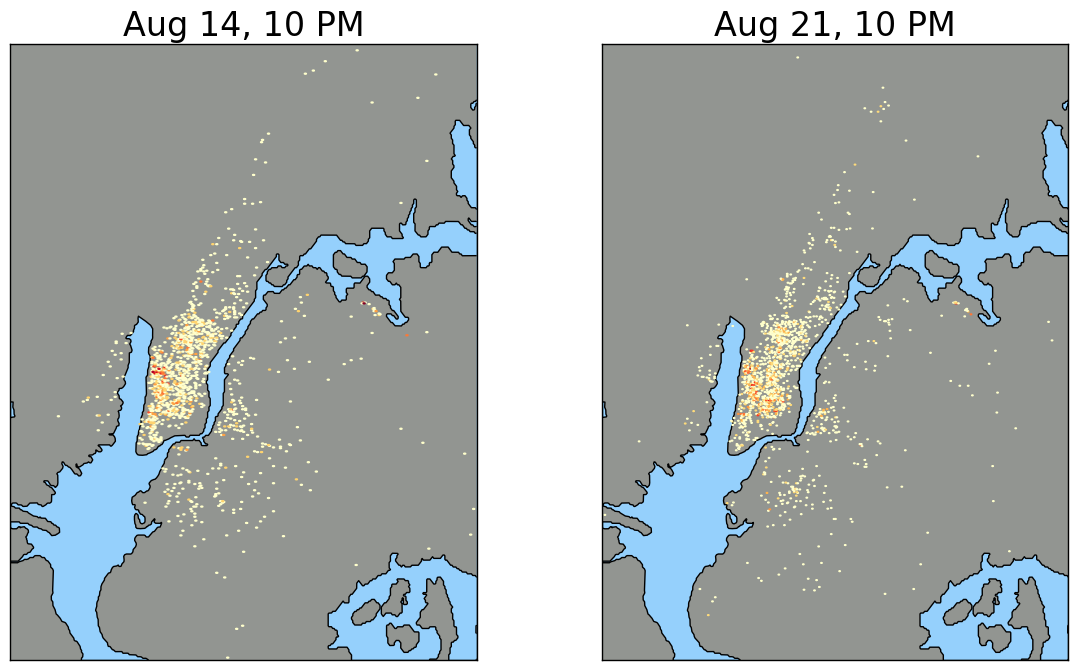

In [88]:
## set day for analysis
target_day = [14, 21]

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9,40.6,-73.8,-74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## hour
hrs = 22

## axis locations
ax_loc = [121, 122]

## title strings
title_str = ['Aug 14, 10 PM', 'Aug 21, 10 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['day'] == target_day[ii]) & (rides['hour'] == hrs)]

    ## plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)


In [89]:
# Initialize a map centered around the mean coordinates
map_center = [rides_this_hour['lat'].mean(), rides_this_hour['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add ride locations as points on the map
for _, row in rides_this_hour.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Display the interactive map
m

# DBSCAN Clustering + Map Visual

In [90]:
def get_hot_spots(max_distance,min_cars,ride_data):

    ## get coordinates from ride data
    coords = ride_data[['lat', 'lon']].values

    ## calculate epsilon parameter using the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian

    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.fit_predict(np.radians(coords))

    # Add cluster labels to ride_data
    ride_data['cluster'] = cluster_labels

    ## group the clusters
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

    ## report
    print('Number of clusters: {}'.format(num_clusters))

    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []

    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))

    hot_spots = {
        'lon': lon,
        'lat': lat,
        'num_members': num_members
    }

    return hot_spots, ride_data

In [91]:
## get ride data
ride_data = rides.loc[(rides['day']== 21) & (rides['hour'] > 15)]

## maximum distance between two cluster members in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 25

## call the get_hot_spots function
hot_spots, ride_data_with_clusters = get_hot_spots(max_distance, min_pickups, ride_data)

<ipython-input-90-4657a034b017>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_data['cluster'] = cluster_labels


Number of clusters: 55


In [92]:
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# Center the map on the average location of all hotspots
map_center = [np.mean(hot_spots['lat']), np.mean(hot_spots['lon'])]
m = folium.Map(location=map_center, zoom_start=12)

# Normalize the color scale for folium
color_scale = np.log(hot_spots['num_members'])
normalized_colors = (color_scale - color_scale.min()) / (color_scale.max() - color_scale.min())
colormap = cm.get_cmap("cool")

# Add each hotspot to the map
for lon, lat, intensity, color in zip(hot_spots['lon'], hot_spots['lat'], hot_spots['num_members'], normalized_colors):
    # Convert color to hex using matplotlib's colors module
    color_hex = colors.to_hex(colormap(color))

    folium.CircleMarker(
        location=[lat, lon],
        radius=5 + (intensity / max(hot_spots['num_members']) * 10),  # Adjust size based on intensity
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

<ipython-input-92-21412f2b7d50>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("cool")


# LSTM Modeling

In [93]:
# Group by 'day' and 'hour' and sum up the 'ride_count'
aggregated_ride_data = hourly_ride_data.groupby(['day', 'hour'])['ride_count'].sum().reset_index()

# Now check the first few rows of the aggregated data
print(aggregated_ride_data.head())

   day  hour  ride_count
0    1     0         734
1    1     1         451
2    1     2         289
3    1     3         318
4    1     4         412


In [101]:
from sklearn.preprocessing import MinMaxScaler
# Function to create sequences for LSTM input
def create_sequences(data, time_steps=24):
    sequences = []
    targets = []
    for i in range(len(data) - time_steps):
        sequence = data[i:i + time_steps, :-2] # Input sequence (time_steps length)
        sequences.append(sequence)
        target = data[i + time_steps, -2] # Target value (next time step)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Extract ride count data and aggregate by day and hour
aggregated_ride_data = hourly_ride_data.groupby(['day', 'hour']).agg({
    'ride_count': 'sum',
    'lat': 'mean',
    'lon': 'mean'
}).reset_index()

# Convert ride count to numpy array for LSTM input
ride_counts = aggregated_ride_data[['ride_count', 'lat', 'lon']].values

# Normalize the ride count data
scaler = MinMaxScaler(feature_range=(0, 1))
ride_counts_normalized = scaler.fit_transform(ride_counts.reshape(-1, 1))

# Prepare the sequences for LSTM model
X, y = create_sequences(ride_counts, time_steps=24)

# Reshape X into 3D array for LSTM input (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)  # Output layer predicts demand for the next time step
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the LSTM model with a smaller learning rate
model = create_lstm_model((X.shape[1], X.shape[2]))
# optimizer = Adam(learning_rate=0.001)  # Try lowering the learning rate
# model.compile(optimizer=optimizer, loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
history

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 127093.8281 - val_loss: 71507.0000
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 100322.1250 - val_loss: 95541.8984
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 63951.2969 - val_loss: 37310.2656
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 50490.1445 - val_loss: 42761.9531
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 75343.4062 - val_loss: 46450.3359
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 74922.9844 - val_loss: 74882.0781
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 85569.2812 - val_loss: 32607.7266
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 41741.8203 - val_loss: 43288.3008
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 37147.0977 - val_loss: 25422.5918
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 27898.2383 - val_loss: 15509.9775
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 26499.6

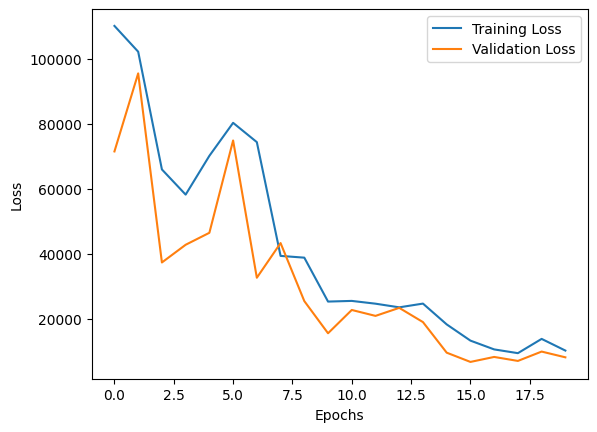

In [103]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

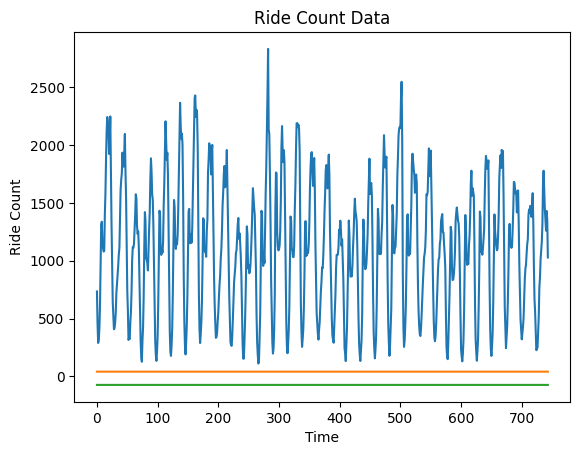

In [104]:
# Visualize the ride counts
plt.plot(ride_counts)
plt.title('Ride Count Data')
plt.xlabel('Time')
plt.ylabel('Ride Count')
plt.show()

In [107]:
# Check the columns in the weekday_hourly_avg DataFrame
print(weekday_hourly_avg.columns)

Index(['weekday', 'hour', 'average_rides'], dtype='object')


In [112]:
# Latitude and Longitude in decimal degrees
lat_center = 40.7455   # Decimal degrees for 40°44′44″N
lon_center = -73.9647  # Decimal degrees for 73°57′53″W

# Define a small radius (in decimal degrees)
# 1 degree of latitude is approximately 111 kilometers.
# 1 degree of longitude varies depending on latitude but roughly 111 km at the equator.
# A small radius like 1 km can be converted to degrees as 1/111 ≈ 0.009 degrees

radius_in_km = 1
radius_in_degrees = radius_in_km / 111  # Convert km to degrees (approximately)

In [113]:
# Predict the next demand for the given sequences
predictions = model.predict(X)

# Flatten the predictions for easier handling (if predictions are 2D)
predictions_flat = predictions.flatten()

# Get the indices of the top 10 predictions (highest predicted demand)
top_predictions = np.argsort(predictions_flat)[-10:][::-1]

# Ensure top_predictions are within the bounds of weekday_hourly_avg
top_predictions = top_predictions[top_predictions < len(hourly_ride_data)]

# Get the top 10 predictions (highest predicted demand)
top_coordinates = hourly_ride_data.iloc[top_predictions][['lat', 'lon']]

# Define the bounding box (1 km radius around the point)
lat_min = lat_center - radius_in_degrees
lat_max = lat_center + radius_in_degrees
lon_min = lon_center - radius_in_degrees
lon_max = lon_center + radius_in_degrees

# Filter the top coordinates based on the bounding box
filtered_coordinates = top_coordinates[
    (top_coordinates['lat'] >= lat_min) & (top_coordinates['lat'] <= lat_max) &  # Latitude within bounds
    (top_coordinates['lon'] >= lon_min) & (top_coordinates['lon'] <= lon_max)    # Longitude within bounds
]

top_predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([128,  75, 540,  56, 143,  36, 262, 161, 293, 179])

In [114]:
print("Top 10 Predicted Demand Coordinates:")
print(top_coordinates)

Top 10 Predicted Demand Coordinates:
           lat        lon
128  40.742864 -73.971901
75   40.739897 -73.973999
540  40.737052 -73.967679
56   40.737008 -73.967509
143  40.731881 -73.977867
36   40.738251 -73.970982
262  40.731097 -73.966798
161  40.742431 -73.976914
293  40.737155 -73.967723
179  40.743393 -73.972826


In [115]:
print("Top coordinates within the specified radius:")
print(filtered_coordinates)

Top coordinates within the specified radius:
           lat        lon
128  40.742864 -73.971901
540  40.737052 -73.967679
56   40.737008 -73.967509
36   40.738251 -73.970982
293  40.737155 -73.967723
179  40.743393 -73.972826
